In [2]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

import pandas as pd
import datetime

import pymc3 as pm

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [10]:
with open("data/onset_by_date.pickle","rb") as f:
    onsets_per_date = pickle.load(f)

with open("data/onsets_by_date_diff.pickle","rb") as f:
    onsets_per_date_diff = pickle.load(f)
    
publishing_start = datetime.date(2020,3,4)  # Startdate of epicurves, first occurence in situation-report
onset_start = datetime.date(2020,2,16)    # Startdate of known onsets
onset_diff_start = onset_start + datetime.timedelta(days=1)
    
# Import KRI Nowcasting csv
def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

nowcast_df = pd.read_csv("data/Nowcasting_Zahlen_200528.csv", sep=",") 
ck = nowcast_df.columns
# Renaming of columns
nowcast_df = nowcast_df.rename(columns={ck[0]:"date",ck[1]:"new_infected",ck[2]:"new_infected_low",ck[3]:"new_infected_high"})
nowcast_df = nowcast_df.rename(columns={ck[4]:"new_infected_smooth",ck[5]:"new_infected_smooth_low",ck[6]:"new_infected_smooth_high"})
nowcast_df = nowcast_df.rename(columns={ck[7]:"R_4",ck[8]:"R_4_low",ck[9]:"R_4_high"})
nowcast_df = nowcast_df.rename(columns={ck[10]:"R_4",ck[11]:"R_4_low",ck[12]:"R_4_high"})
# Generate proper timestamps
nowcast_df["date"] = nowcast_df["date"].apply(rdate)

print(nowcast_df.columns)
print(onsets_per_date.shape,onsets_per_date_diff.shape)
print(type(onsets_per_date))

Index(['date', 'new_infected', 'new_infected_low', 'new_infected_high',
       'new_infected_smooth', 'new_infected_smooth_low',
       'new_infected_smooth_high', 'R_4', 'R_4_low', 'R_4_high', 'R_4',
       'R_4_low', 'R_4_high'],
      dtype='object')
(104, 87) (104, 86)
<class 'numpy.ma.core.MaskedArray'>


In [12]:
# Parse RKI DB_dump to get Meldedatums
rki_df = pd.read_csv("data/RKI_COVID19_200529.csv", sep=",") 

cols = [x for x in ["Meldedatum","Refdatum"] if x in rki_df.columns]
for col in cols:
    if col in rki_df:
        rki_df[col] = rki_df[col].apply(rdate)
        
rki_df = rki_df.filter(items=["Meldedatum","Refdatum","NeuerFall","AnzahlFall","IstErkrankungsbeginn"])


In [46]:
# Generate KWs
kw09_start = datetime.date(2020,3,2)
KWs = {}
for i in range(9,21):
    KWs[i] = kw09_start+datetime.timedelta(days=7*(i-9))

# Collect per KW series of known onsets
by_onset_in_kw,by_publication_in_kw = {},{}

for ikw,sdate in KWs.items():
    by_onsets,by_publication = np.zeros(60),np.zeros(60)
    
    onset_i = (sdate-onset_start).days
    pub_i = (sdate-publishing_start).days-1 # Offset as onsets_per_date_diff starts 1 day later
    for i in range(7):
        onset_ii = onset_i+i
        if onset_ii >= 0 and onset_ii < onsets_per_date_diff.shape[0]:
            for j in range(60):
                pub_jj = pub_i + j + i
                if pub_jj >= 0 and pub_jj < onsets_per_date_diff.shape[1]:
            #        print(onset_i,pub_i,"\t",i,j,"\t",onset_ii,pub_jj)
                    by_onsets[j] += onsets_per_date_diff[onset_ii,pub_jj]
    by_onset_in_kw[ikw] = by_onsets


In [47]:
# Count Onsets and Meldungen per KW from RKI DB_dump
melde_delay_by_onset,melde_delay_by_meldung = {},{}
max_range = 60
for i,k in enumerate(sorted(KWs.keys())):
    start = KWs[k]
    end = start + datetime.timedelta(days=7)
    
    rki_meld_week = rki_df[(rki_df["Meldedatum"] >= start) & (rki_df["Meldedatum"] < end )]
    rki_ref_week = rki_df[(rki_df["Refdatum"] >= start) & (rki_df["Refdatum"] < end)]
    
    odelay,mduration = np.zeros(max_range),np.zeros(max_range)
    # Count Duration between Onset and Meldung by Meldungen in one KW
    for i,x in rki_meld_week.iterrows():
        if x["IstErkrankungsbeginn"] and x["NeuerFall"] != -9:
#         if x["Meldedatum"] != x["Refdatum"] and x["NeuerFall"] != -9:
            delay = (x["Meldedatum"] - x["Refdatum"]).days
            if delay >= 0 and delay < max_range:
                mduration[delay] += x["AnzahlFall"]
    melde_delay_by_meldung[k] = mduration
    # Count Delay between Onset and Meldung by Onset in one KW
    for i,x in rki_ref_week.iterrows():
      #  if x["Meldedatum"] != x["Refdatum"] and x["NeuerFall"] != -9:
        if x["IstErkrankungsbeginn"] and x["NeuerFall"] != -9:
            delay = (x["Meldedatum"] - x["Refdatum"]).days
            if delay >= 0 and delay < max_range:
                odelay[delay] += x["AnzahlFall"]
    melde_delay_by_onset[k] = odelay

# Delay between known onsets and publication in RKI dataset per KW

{9: {0.2: 6, 0.5: 12, 0.8: 22}, 10: {0.2: 6, 0.5: 11, 0.8: 19}, 11: {0.2: 6, 0.5: 10, 0.8: 18}, 12: {0.2: 5, 0.5: 9, 0.8: 16}, 13: {0.2: 4, 0.5: 7, 0.8: 14}, 14: {0.2: 4, 0.5: 7, 0.8: 13}, 15: {0.2: 3, 0.5: 6, 0.8: 11}}
dict_keys([9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])


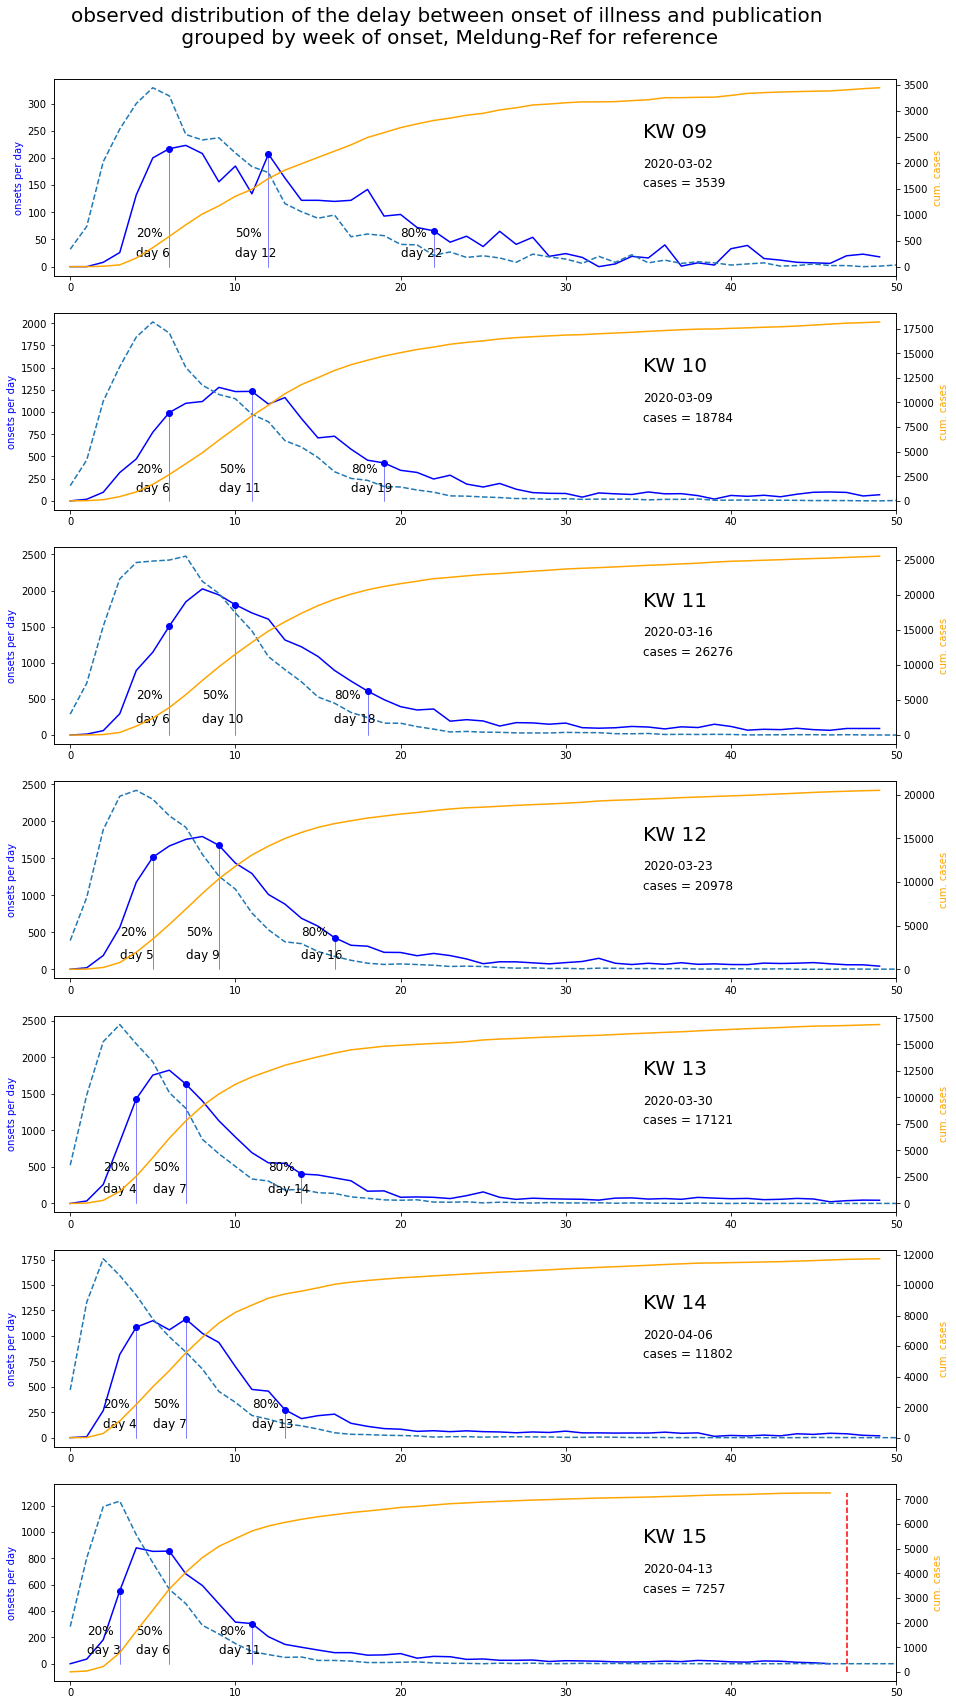

In [48]:
n_weeks = 7
kws = sorted(by_onset_in_kw.keys())[:n_weeks]
# Calculate Levels

levels = [.2,.5,.8]
levels_per_week,levels_per_week_MD = {},{}
for jkw,ikw in enumerate(kws):
    onsets = by_onset_in_kw[ikw]
    cs = np.cumsum(onsets)
    cl = dict(zip(levels,[0]*len(levels))) # Empty dict of discovered levels

    for i,cases in enumerate(cs):
        for l in cl.keys():
            if cases < cs[-1]*l:
                cl[l] = i
    levels_per_week[ikw] = cl
    
print(levels_per_week)
print(melde_delay_by_onset.keys())
    
# Plot
fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("observed distribution of the delay between onset of illness and publication\n grouped by week of onset, Meldung-Ref for reference",fontsize=20)

end_data = onset_start + datetime.timedelta(days=onsets_per_date.shape[0])
max_days = 50

gs = fig.add_gridspec(len(kws), 1)

for jkw,ikw in enumerate(kws):
    onsets = by_onset_in_kw[ikw]
    max_onsets = np.max(onsets)
    ax = fig.add_subplot(gs[jkw,0])
    cs = np.cumsum(onsets)
    
    kw_end_data = KWs[ikw]+datetime.timedelta(days=max_days)
    no_data_days = (end_data-kw_end_data).days
    end = min(max_days,max_days+no_data_days)
    
    ax.text(0.7,.7,"KW %02d"%ikw,transform=ax.transAxes,fontsize=20)
    ax.text(0.7,.55,"%s"%(KWs[ikw]),transform=ax.transAxes,fontsize=12)
    ax.text(0.7,.45,"cases = %d"%(cs[-1]),transform=ax.transAxes,fontsize=12)
    
    for ll,lv in levels_per_week[ikw].items():
        ax.plot([lv],onsets[lv],"o",color="blue")
        ax.plot([lv]*2,[0,onsets[lv]],color="blue",linewidth=.5)
        ax.text(lv-2,max_onsets/4.,"%d%%"%(ll*100),fontsize=12)
        ax.text(lv-2,max_onsets/12.,"day %d"%(lv),fontsize=12)
        
    ax.plot(range(end),onsets[:end],color="blue",label="onsets per day [left]")
    
    ax.plot(melde_delay_by_onset[ikw],"--")

    if no_data_days < 0:
        ax.plot([end]*2,ax.get_ylim(),"--",color="red")
    
    ax.set_ylabel("onsets per day",color="blue")
    ax.set_xlim(-1,max_days)
    
    bx = ax.twinx()
    bx.plot(range(end),cs[:end],color="orange",label="cum. onsets [right]")
    bx.set_ylabel("cum. cases",color="orange")
    bx.set_xlim(-1,max_days)

    

{9: {0.2: 6, 0.5: 12, 0.8: 22}, 10: {0.2: 6, 0.5: 11, 0.8: 19}, 11: {0.2: 6, 0.5: 10, 0.8: 18}, 12: {0.2: 5, 0.5: 9, 0.8: 16}, 13: {0.2: 4, 0.5: 7, 0.8: 14}, 14: {0.2: 4, 0.5: 7, 0.8: 13}, 15: {0.2: 3, 0.5: 6, 0.8: 11}}
[9, 10, 11, 12, 13, 14, 15] 0.2 [6, 6, 6, 5, 4, 4, 3]
[9, 10, 11, 12, 13, 14, 15] 0.5 [12, 11, 10, 9, 7, 7, 6]
[9, 10, 11, 12, 13, 14, 15] 0.8 [22, 19, 18, 16, 14, 13, 11]


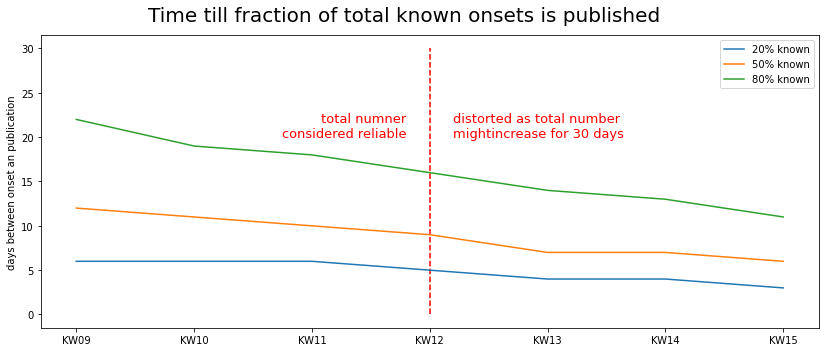

In [49]:
# Transpose levels:
t_levels = {}
for l in levels:
    t_levels[l] = []
for kw in kws:
    for k,v in levels_per_week[kw].items():
        t_levels[k].append(v)

print(levels_per_week)
# Plot
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("Time till fraction of total known onsets is published",fontsize=20)

gs = fig.add_gridspec(2, 1)
ax = fig.add_subplot(gs[0,0])
full_end = kws[-1]-3
ax.plot([full_end]*2,[0,30],"--",color="red")
ax.text(full_end+.2,20,"distorted as total number\nmightincrease for 30 days",color="red",fontsize=13)
ax.text(full_end-.2,20,"total numner\nconsidered reliable",color="red",fontsize=13,horizontalalignment="right")

for k,v in t_levels.items():
    print(kws,k,v)
    ax.plot(kws,v,label="%d%% known"%(k*100))
    
ax.set_xticks(kws)
ax.set_xticklabels(["KW%02d"%x for x in kws ])
ax.set_ylabel("days between onset an publication")
ax.legend()


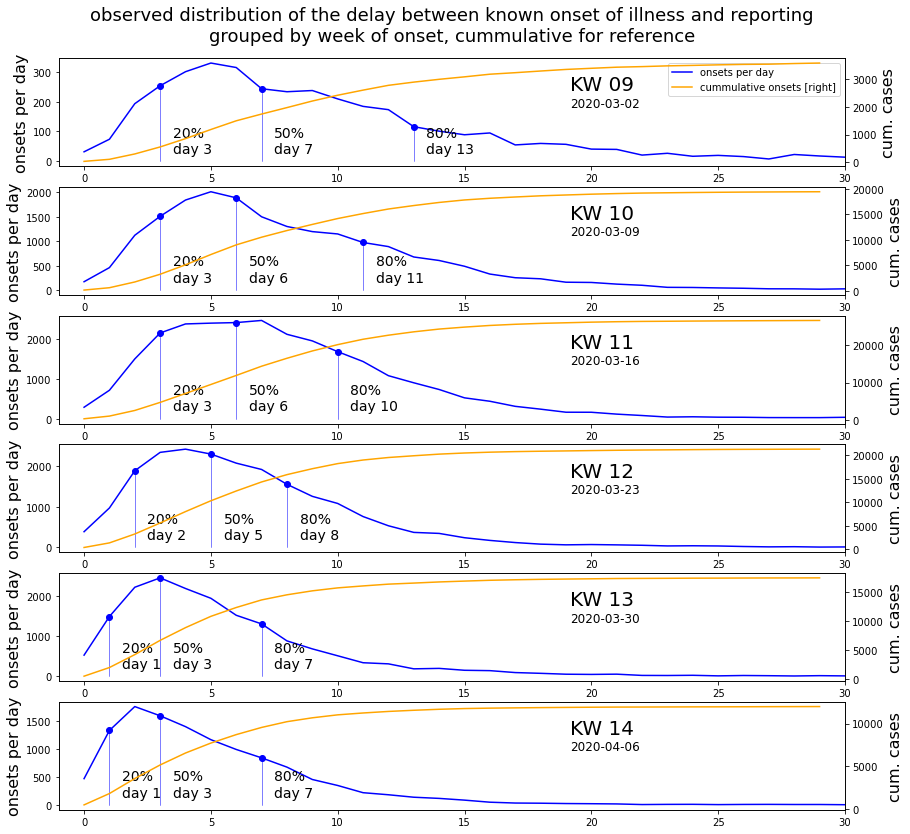

In [72]:
### Actual figure for the comments
n_weeks = 6
kws = sorted(by_onset_in_kw.keys())

# Calculate Levels
levels = [.2,.5,.8]
levels_per_week,levels_per_week_MD = {},{}
for jkw,ikw in enumerate(kws):
    onsets = melde_delay_by_onset[ikw]
    cs = np.cumsum(onsets)
    cl = dict(zip(levels,[0]*len(levels))) # Empty dict of discovered levels

    for i,cases in enumerate(cs):
        for l in cl.keys():
            if cases < cs[-1]*l:
                cl[l] = i
    levels_per_week[ikw] = cl
    
# Plot
fig = plt.figure(figsize=(13,12))
fig.subplots_adjust(wspace=0.33,hspace=0.19,left=0.08,right=0.92,top=0.92,bottom=0.05)
fig.suptitle("observed distribution of the delay between known onset of illness and reporting\ngrouped by week of onset, cummulative for reference",fontsize=18)

end_data = onset_start + datetime.timedelta(days=onsets_per_date.shape[0])
max_days = 30

gs = fig.add_gridspec(n_weeks, 1)

for jkw,ikw in enumerate(kws[:n_weeks]):
    onsets = melde_delay_by_onset[ikw]
    max_onsets = np.max(onsets)
    ax = fig.add_subplot(gs[jkw,0])
    cs = np.cumsum(melde_delay_by_onset[ikw])
    
    kw_end_data = KWs[ikw]+datetime.timedelta(days=max_days)
    no_data_days = (end_data-kw_end_data).days
    end = min(max_days,max_days+no_data_days)
    
    ax.text(0.65,.7,"KW %02d"%ikw,transform=ax.transAxes,fontsize=20)
    ax.text(0.65,.55,"%s"%(KWs[ikw]),transform=ax.transAxes,fontsize=12)
#    ax.text(0.7,.45,"cases = %d"%(cs[-1]),transform=ax.transAxes,fontsize=12)
    
    for ll,lv in levels_per_week[ikw].items():
        ax.plot([lv],onsets[lv],"o",color="blue")
        ax.plot([lv]*2,[0,onsets[lv]],color="blue",linewidth=.5)
        ax.text(lv+.5,max_onsets/4.,"%d%%"%(ll*100),fontsize=14)
        ax.text(lv+.5,max_onsets/12.,"day %d"%(lv),fontsize=14)
        
 #   ax.plot(range(end),onsets[:end],color="blue",label="onsets per day [left]")
    
    ax.plot(melde_delay_by_onset[ikw],color="blue",label="onsets per day")
    
    
    ax.set_ylabel("onsets per day",color="black",fontsize=16)#"blue"
    ax.set_xlim(-1,max_days)
    
    bx = ax.twinx()
    bx.plot(range(end),cs[:end],color="orange",label="cummulative onsets [right]")
    ax.plot([0],[0],color="orange",label="cummulative onsets [right]")
    bx.set_ylabel("cum. cases",color="black",fontsize=16)#"orange"
    bx.set_xlim(-1,max_days)

    if jkw == 0:
        ax.legend()
fig.savefig("OnsetMeldungDelay.svg")